# Team Sirius: Solution Overview

We performed the following steps to approach the problem aiming at accurate job matching prediction.

- **Exploratory Data Analysis**  
  - Missing Values  
  - Unimportant Columns  
  - Diverse Textual Data  
  - Date Columns in Textual Form  
  - Numeric Columns in Textual Form  

- **Data Manipulation**  
  - Feature Selection  
  - Data Extraction  
  - Numeric Data Extraction  
  - Textual Data Embedding  
  - Hybrid Embedding  
  - Grouped Hybrid Embedding Training  

- **Predictor Model Training**  
  - Input Feature Preparation  
  - Model Exploration and Selection  
  - Hyperparameter Tuning  
  - Model Architecture  
  - Training  

- **Inference on Test Set**  
  - K-Fold Scheme  
  - Folded Inference

# Flow Chart

![Flow Chart](https://fgrgesdffdasdasd.netlify.app/flowchart.png)

# Installations

In [1]:
!pip install -U lightgbm

# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
import ast
import lightgbm as lgbm
from ast import literal_eval
import re
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from itertools import chain
from collections import Counter

# Basic Utility Functions

In [3]:
def get_formatted_time_date():
    now = datetime.now()
    hour = now.strftime("%I").lstrip('0')  # Remove leading zero from hour
    minute = now.strftime("%M")
    am_pm = now.strftime("%p").lower()
    day = now.strftime("%d").lstrip('0')  # Remove leading zero from day
    month = now.strftime("%b").lower()  # Abbreviated month name in lowercase
    year = now.strftime("%Y")
    return f"{hour}-{minute}-{am_pm}-{day}-{month}-{year}"

# Load Train and Test Dataset

In [4]:
train = pd.read_csv('/kaggle/input/bitfest-datathon-2025/train.csv')
test = pd.read_csv('/kaggle/input/bitfest-datathon-2025/test.csv')

# Exploratory Data Analysis (EDA)

In [5]:
df = train.copy()

# Basic EDA

In [6]:
df.head(2)

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,online_links,issue_dates,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.85
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.75


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7635 entries, 0 to 7634
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   address                              633 non-null    object 
 1   career_objective                     3794 non-null   object 
 2   skills                               7592 non-null   object 
 3   educational_institution_name         7574 non-null   object 
 4   degree_names                         7574 non-null   object 
 5   passing_years                        7574 non-null   object 
 6   educational_results                  7574 non-null   object 
 7   result_types                         7574 non-null   object 
 8   major_field_of_studies               7574 non-null   object 
 9   professional_company_names           7568 non-null   object 
 10  company_urls                         7568 non-null   object 
 11  start_dates                   

In [8]:
df.describe()

,matched_score
count,7635.000000
mean,0.660667
std,0.167405
min,0.000000
25%,0.576667
50%,0.683333
75%,0.793333
max,0.970000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


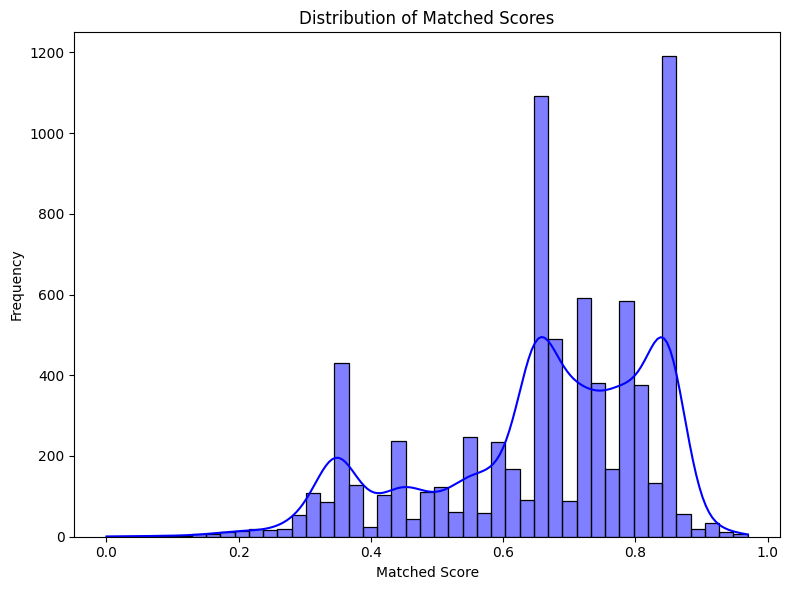

In [9]:
# Plot distribution of matched_score
plt.figure(figsize=(8, 6))
sns.histplot(df['matched_score'], kde=True, color='blue')
plt.title('Distribution of Matched Scores')
plt.xlabel('Matched Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

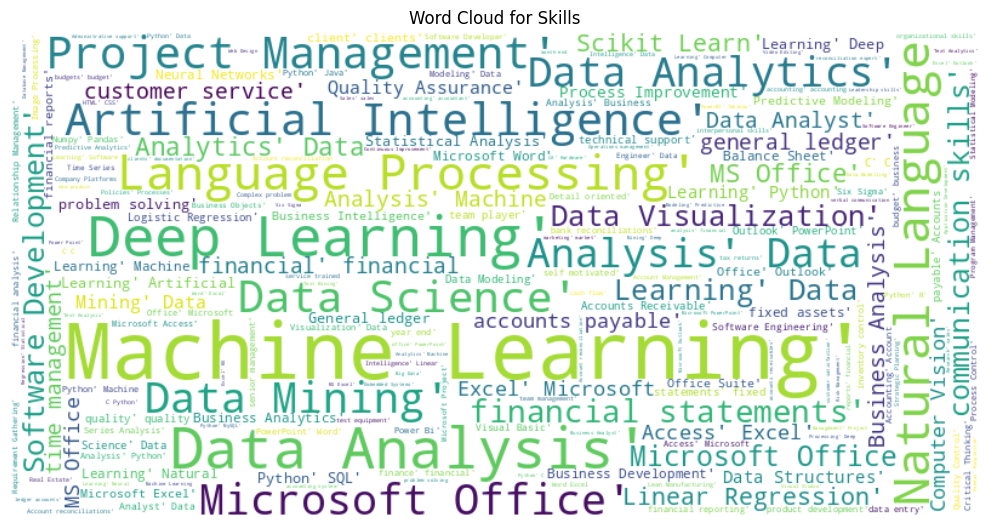

In [10]:
from wordcloud import WordCloud

# Create a word cloud for the 'skills' column
skills_text = ' '.join(df['skills'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Skills')
plt.tight_layout()
plt.show()


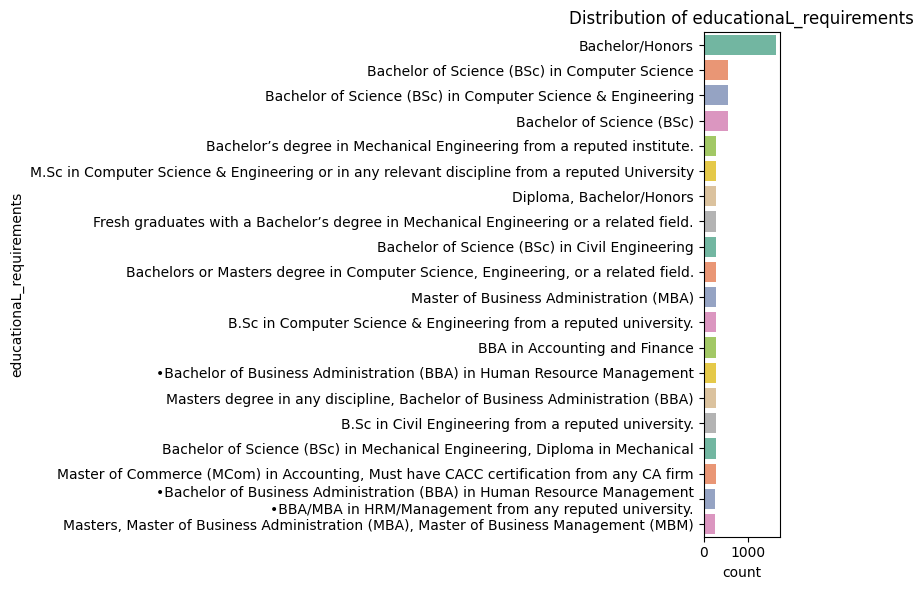

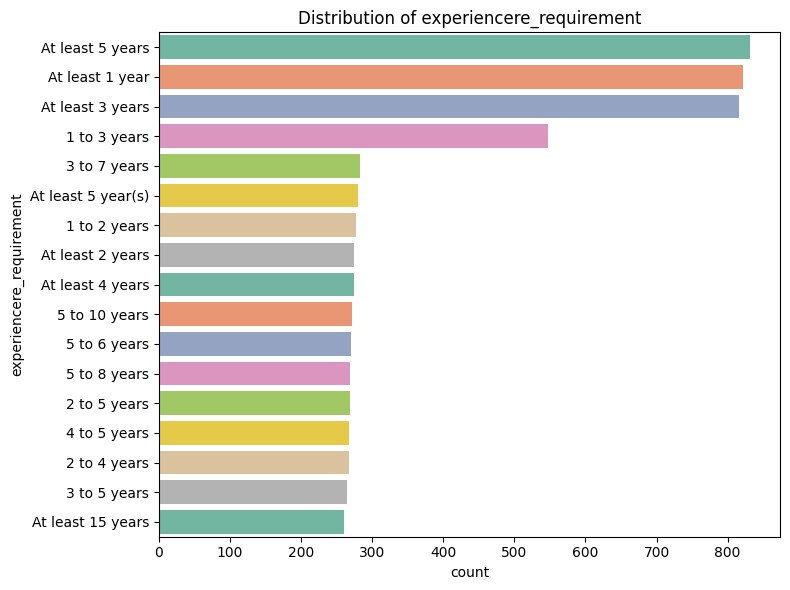

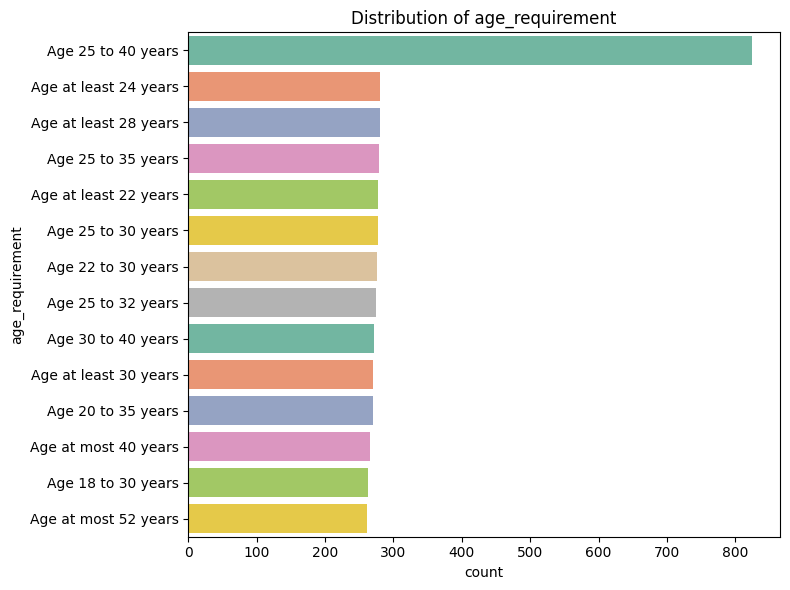

In [11]:
# Distribution of categorical variables
categorical_cols = ['educationaL_requirements', 'experiencere_requirement', 'age_requirement']
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(y=df[col], order=df[col].value_counts().index, palette="Set2")
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Analysis of Missing Values

In [12]:
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentages
})
missing_info

,Missing Values,Percentage
address,7002,91.709234
career_objective,3841,50.307793
skills,43,0.563196
educational_institution_name,61,0.798952
degree_names,61,0.798952
passing_years,61,0.798952
educational_results,61,0.798952
result_types,61,0.798952
major_field_of_studies,61,0.798952
professional_company_names,67,0.877538


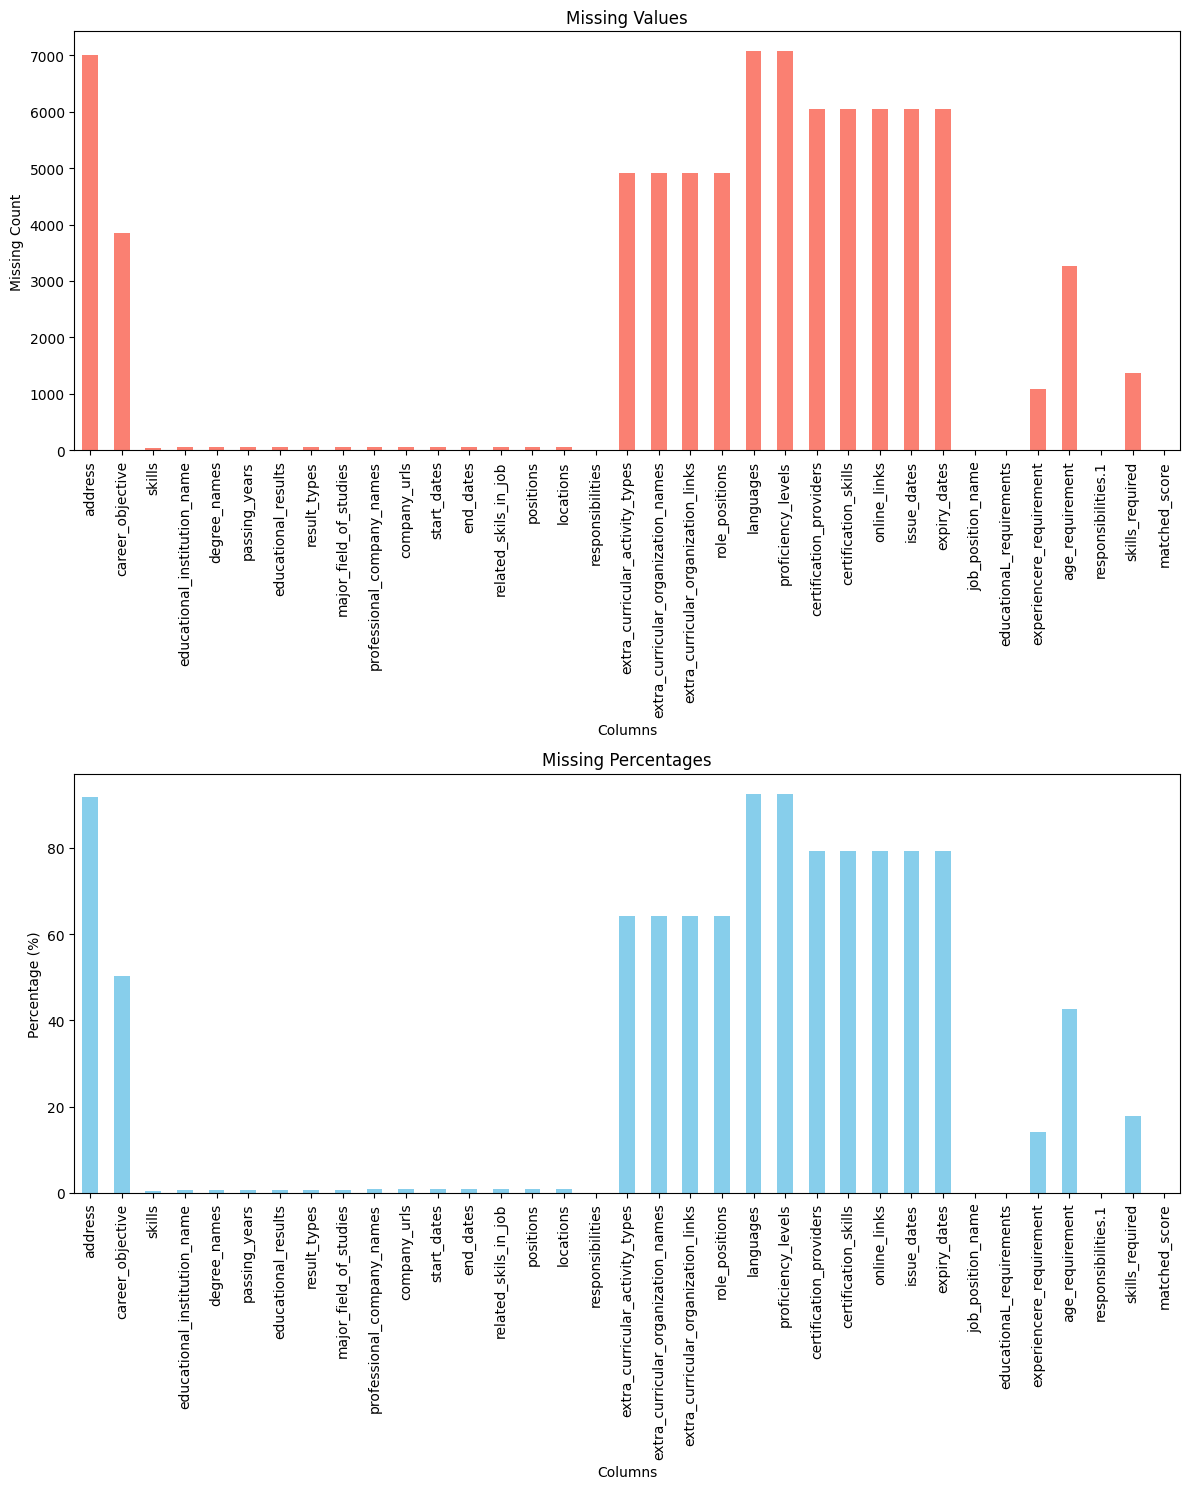

In [13]:
# Plot missing values and percentages
plt.figure(figsize=(12, 15))

# Bar plot for missing values
plt.subplot(2, 1, 1)
missing_info['Missing Values'].plot(kind='bar', color='salmon')
plt.title('Missing Values')
plt.xlabel('Columns')
plt.ylabel('Missing Count')
plt.xticks(rotation=90)

# Bar plot for missing percentages
plt.subplot(2,1, 2)
missing_info['Percentage'].plot(kind='bar', color='skyblue')
plt.title('Missing Percentages')
plt.xlabel('Columns')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


# Observations

As a whole, our observations are:

- **Exploratory Data Analysis:**
    - **Missing Values:** First, inspecting the train and test data, we find that several columns have significant amount of missing values. These include address, languages, proficiency_levels, certification_providers, extra_curricular_activity_types and many more.
    - **Unimportant columns:** We also notice that some fields clearly do not contribute at all to the prediction problem, for instance, address, company_urls, online_links etc.
    - **Diverse Textual Data:** We notice that a lot of the columns contain textual data which have a rather high number of unique values. One exception is ‘educationaL_requirements’ which contains 20 unique values. Others like ‘skills’, ‘responsibilties’ seem to include highly diverse textual data
    - **Date Columns in Textual Form:** We note that, columns like ‘start_dates’, ‘end_dates’ actually present date values, but are given in text format, like ‘18/2022’ or ‘Current’ etc
    - **Numeric Columns in Textual Form:** We also note that, some of the columns like ‘experiencere_requirement’, ‘age_requirement’ etc actually present minimum and maximum allowed values, but are given in text format, like ‘2 to 5 years’

# Data Processing

Now we proceed to our next step:

- **Data Manipulation**
    - **Feature Selection:** Based on our observations, we decide to ignore some features completely. These are, address, extra_curricular_activity_types, extra_curricular_organization_names, extra_curricular_organization_links, role_positions, languages, proficiency_levels, certification_providers, certification_skills, online_links, issue_dates, expiry_dates
    - **Data Extraction:** From the columns ‘start_dates’, ‘end_date’, we extract exact dates in (month, year) format using a Python based parser function.
    - **Numeric Data Extraction:** From the columns, ‘experiencere_requirement’, ‘age_requirement’, we extract minimum and maximum values using Python-based parser.
    - **Textual Data Embedding:** We embed the textual columns data using a grouped hybrid embedder.
    - **Hybrid Embedding:** We use a concatenation of the vectors obtained from each of these embeddings
        - **Word2Vec**: Semantic embeddings based on word contexts.
        - **TF-IDF (Term Frequency-Inverse Document Frequency)**: Measures term importance within and across documents.
        - **Hashing Vectorizer**: Hash-based feature extraction for text representation.
        - **Count Vectorizer**: Frequency-based feature extraction for n-grams.
        - **Truncated SVD (Singular Value Decomposition)**: Reduces dimensionality of Count Vectorizer outputs.
        - **BM25**: A ranking function for text retrieval based on term frequencies and document lengths.
        - **Mean Pooling**: Aggregates features by their mean value.
        - **Max Pooling**: Aggregates features by their maximum value.
    - **Grouped Hybrid Embedding Training:** Please note here, we do not use any pre-trained embedding model. These are standard libraries that are available in Python, without any model weights. Therefore, we extract column-group-wise corpora from the provided dataset and fit embedders on those texts. For instance, we consider 'skills_required', 'related_skils_in_job', 'skills', 'responsibilities', these four features for one group. That means, we fit embedders on all the texts present in these columns over all rows. Then we infer embeddings for the test data.

# Numeric Feature Extraction

In [14]:
numeric_cols = []

# Date Parsing

In [15]:
df = train.copy() 
df.head(3)

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,online_links,issue_dates,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],...,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667


In [16]:
df = df[['start_dates', 'end_dates']]
df.head(10)

,start_dates,end_dates
0,['Nov 2019'],['Till Date']
1,['Sep 2019'],['Till Date']
2,['June 2018'],['Till Date']
3,"['January 2011', 'January 2008', 'January 2006...","['November 2015', 'January 2010', 'January 200..."
4,"['January 2016', 'January 2016', 'January 2012...","['Current', 'January 2016', 'January 2015', 'J..."
5,"['August 2006', 'August 2013', 'July 2014']","['January 2013', 'September 2014', 'Current']"
6,['Jan 2019'],['Sep 2019']
7,"['January 2013', 'January 2011', 'January 2005']","['Current', 'January 2012', 'January 2011']"
8,['Jun 2019'],['till date']
9,['Jan 2019'],['Till Date']


In [17]:
def parse_date(date_str: str):
   if not isinstance(date_str, str):
       return None 
       
   # Clean input
   date_str = date_str.strip().lower()
   
   # Handle special cases
   special_cases = {'current', 'present', 'ongoing', 'till date', 'till date', '∞', 'n/a'}
   if date_str in special_cases:
       return (6, 2022)
       
   # Rest of the function remains same as before
   # Handle cases ending with XX or xx
   if date_str.endswith('xx'):
       return None
       
   # Dictionary for month names
   month_names = {
       'jan': 1, 'january': 1,
       'feb': 2, 'february': 2,
       'mar': 3, 'march': 3,
       'apr': 4, 'april': 4,
       'may': 5,
       'jun': 6, 'june': 6,
       'jul': 7, 'july': 7,
       'aug': 8, 'august': 8,
       'sep': 9, 'sept': 9, 'september': 9,
       'oct': 10, 'october': 10,
       'nov': 11, 'november': 11,
       'dec': 12, 'december': 12
   }
   
   # Patterns for different date formats
   patterns = [
       # MM/YYYY or M/YYYY
       r'^(\d{1,2})/(\d{4})$',
       # Month YYYY or Month. YYYY
       r'^([a-z]+\.?\s+)(\d{4})$',
       # Month DD, YYYY
       r'^([a-z]+\.?\s+)\d{1,2},\s*(\d{4})$',
       # YYYY only
       r'^(\d{4})$',
       # Season YYYY
       r'^(spring|summer|fall|winter)\s+(\d{4})$'
   ]
   
   # Try each pattern
   for pattern in patterns:
       match = re.match(pattern, date_str)
       if match:
           groups = match.groups()
           
           # Handle MM/YYYY format
           if '/' in date_str:
               month = int(groups[0])
               year = int(groups[1])
               return (month, year) if 1 <= month <= 12 else None
           
           # Handle year-only format
           elif len(groups) == 1:
               year = int(groups[0])
               return None if year < 1900 else (1, year)
           
           # Handle month name formats
           else:
               month_str = groups[0].strip('. ').lower()
               year = int(groups[1])
               
               if month_str in month_names:
                   return (month_names[month_str], year)
                   
   return None

In [18]:
date_cols = ['start_dates', 'end_dates']

In [19]:
def calculate_experience_duration(row):
    # Safely evaluate string representations of lists
    start_dates = eval(row['start_dates']) if isinstance(row['start_dates'], str) else row['start_dates']
    end_dates = eval(row['end_dates']) if isinstance(row['end_dates'], str) else row['end_dates']
    
    total_months = 0

    if not (isinstance(start_dates, list) and isinstance(end_dates, list)):
        return 0
    
    # Process each pair of start and end dates
    for start_str, end_str in zip(start_dates, end_dates):
        start_tuple = parse_date(start_str)
        end_tuple = parse_date(end_str)
        
        if start_tuple and end_tuple:
            start_month, start_year = start_tuple
            end_month, end_year = end_tuple
            
            # Calculate months difference
            months = (end_year - start_year) * 12 + (end_month - start_month)
            if months > 0:
                total_months += months
    
    return total_months

# Example usage:
# Assuming you have a DataFrame with 'start_dates' and 'end_dates' columns
def process_experience_data(df):
    # for c in date_cols:
    #     df[c] = df[c].apply(lambda x: f(x))
    
    # Create a copy to avoid modifying the original DataFrame
    df_copy = df.copy()
    
    # Calculate duration for each row
    df_copy['duration_months'] = df_copy.apply(calculate_experience_duration, axis=1)
    
    # Optionally add years column
    df_copy['duration_years'] = df_copy['duration_months'] / 12
    
    return df_copy

In [20]:
date_numeric_cols = ['duration_months', 'duration_years']
numeric_cols += date_numeric_cols

In [21]:
df = train.copy()
df = df[:]
df = process_experience_data(df)[date_cols + date_numeric_cols]
df.head(3)

,start_dates,end_dates,duration_months,duration_years
0,['Nov 2019'],['Till Date'],31,2.583333
1,['Sep 2019'],['Till Date'],33,2.750000
2,['June 2018'],['Till Date'],48,4.000000


# Age and Experience Requirements Parsing

In [22]:
def parse_requirements(df):
    """
    Parse experience and age requirements to create min/max columns.
    Returns DataFrame with 4 new columns:
    - experience_min_years
    - experience_max_years
    - age_min_years
    - age_max_years
    """
    import re
    
    def parse_experience(text):
        if pd.isna(text):
            return None, None
            
        # Convert to string to ensure string operations work
        text = str(text).lower().strip()
        
        # Handle "At least X year(s)" format
        if "at least" in text:
            years = re.findall(r'(\d+)', text)[0]
            return float(years), None
            
        # Handle "X to Y years" format
        elif "to" in text:
            numbers = re.findall(r'(\d+)', text)
            return float(numbers[0]), float(numbers[1])
            
        return None, None

    def parse_age(text):
        if pd.isna(text):
            return None, None
            
        text = str(text).lower().strip()
        
        # Handle "Age at least X years" format
        if "at least" in text:
            years = re.findall(r'(\d+)', text)[0]
            return float(years), None
            
        # Handle "Age at most X years" format
        elif "at most" in text:
            years = re.findall(r'(\d+)', text)[0]
            return None, float(years)
            
        # Handle "Age X to Y years" format
        elif "to" in text:
            numbers = re.findall(r'(\d+)', text)
            return float(numbers[0]), float(numbers[1])
            
        return None, None

    # Create new columns for experience requirements
    df['experience_min_years'], df['experience_max_years'] = zip(*df['experiencere_requirement'].apply(parse_experience))
    df['experience_min_months'] = df['experience_min_years']*12
    df['experience_max_months'] = df['experience_max_years']*12
    
    # Create new columns for age requirements
    df['age_min_years'], df['age_max_years'] = zip(*df['age_requirement'].apply(parse_age))
    
    return df

In [23]:
req_numeric_cols = ['experience_min_years', 'experience_max_years', 'experience_min_months', 'experience_max_months']
numeric_cols += req_numeric_cols

In [24]:
df = train.copy()
df = df[:3]
df = parse_requirements(df)[req_numeric_cols]
df

,experience_min_years,experience_max_years,experience_min_months,experience_max_months
0,1.0,None,12.0,NaN
1,5.0,None,60.0,NaN
2,3.0,None,36.0,NaN


# Total Numeric Columns

In [25]:
numeric_cols = date_numeric_cols + req_numeric_cols

In [26]:
def prepare_numeric_cols(df):
    df = process_experience_data(df)
    df = parse_requirements(df)
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    return df

In [27]:
df = train.copy() 
df = prepare_numeric_cols(df)
df.head(3)[numeric_cols]

,duration_months,duration_years,experience_min_years,experience_max_years,experience_min_months,experience_max_months
0,31,2.583333,1.0,5.270569,12.0,63.246823
1,33,2.750000,5.0,5.270569,60.0,63.246823
2,48,4.000000,3.0,5.270569,36.0,63.246823


# Embedders For Textual Feature Embedding

In [28]:
MAX_FEATURES = 224
VECTOR_SIZE = 100

### Basic Embedder

In [29]:
class ColumnEmbedder:
    def __init__(self, max_features=256):
        self.vectorizers = {}
        self.max_features = max_features
        self.is_fitted = {}
        
    def preprocess_text(self, text):
        if pd.isna(text):
            return ''
        text = str(text).lower().strip()
        text = text.replace('"', ' ').replace("'", ' ')
        text = text.replace('- ', ' ').replace('• ', ' ')
        return text
        
    def preprocess_list(self, text):
        if pd.isna(text):
            return ''
        try:
            items = ast.literal_eval(text) if isinstance(text, str) else text
            if isinstance(items, list):
                return ' '.join(str(item) for item in items if item)
        except:
            return str(text)
        return str(text)

    def fit(self, texts, column_name):
        if column_name not in self.vectorizers:
            self.vectorizers[column_name] = TfidfVectorizer(
                max_features=self.max_features,
                ngram_range=(1, 2),
                token_pattern=r'(?u)\b\w[\w-]*\w\b',
                lowercase=True,
                analyzer='word',
                min_df=1,
                norm='l2'
            )
            
        processed_texts = [self.preprocess_text(t) if str(t).find('[')==-1 else self.preprocess_list(t) for t in texts]
        
        self.vectorizers[column_name].fit(processed_texts)
        self.is_fitted[column_name] = True
        return self

    def transform(self, texts, column_name):
        if column_name not in self.vectorizers or not self.is_fitted.get(column_name):
            raise ValueError(f"Vectorizer for {column_name} must be fitted first")
            
        processed_texts = [self.preprocess_text(t) if str(t).find('[')==-1 else self.preprocess_list(t) for t in texts]
        
        return self.vectorizers[column_name].transform(processed_texts).toarray()


### Hybrid Embedder

In [30]:
class HybridEmbedder:
    def __init__(self, max_features=50, vector_size=50, window=5, min_count=1, k1=1.5, b=0.75):
        self.max_features = max_features
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.k1 = k1
        self.b = b
        
        # Initialize all embedders
        self.w2v_models = {}
        self.tfidf_vectors = {}
        self.hash_vectors = {}
        self.count_vectors = {}
        self.svd_models = {}
        self.avdl = {}
        self.is_fitted = {}
        
    def preprocess_text(self, text):
        if pd.isna(text):
            return ''
        text = str(text).lower().strip()
        text = text.replace('"', ' ').replace("'", ' ')
        text = text.replace('- ', ' ').replace('• ', ' ')
        return text
    
    def preprocess_for_w2v(self, text):
        return self.preprocess_text(text).split()
        
    def preprocess_list(self, text):
        if pd.isna(text):
            return ''
        try:
            items = ast.literal_eval(text) if isinstance(text, str) else text
            if isinstance(items, list):
                return self.preprocess_text(' '.join(str(item) for item in items if item))
        except:
            return self.preprocess_text(str(text))
        return self.preprocess_text(str(text))

    def fit(self, texts, column_name):
        processed_texts = [self.preprocess_text(t) if str(t).find('[')==-1 else self.preprocess_list(t) for t in texts]
        w2v_texts = [self.preprocess_for_w2v(t) for t in processed_texts]
        
        # Fit Word2Vec
        self.w2v_models[column_name] = Word2Vec(
            sentences=w2v_texts,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=4
        )
        
        # Fit TF-IDF
        self.tfidf_vectors[column_name] = TfidfVectorizer(
            max_features=self.max_features,
            ngram_range=(1, 5),
            token_pattern=r'(?u)\b\w[\w-]*\w\b',
            min_df=1
        )
        tfidf_matrix = self.tfidf_vectors[column_name].fit_transform(processed_texts)
        
        # Fit Hash Vectorizer
        self.hash_vectors[column_name] = HashingVectorizer(
            n_features=self.max_features,
            ngram_range=(1, 5),
            alternate_sign=False
        )
        
        # Fit Count Vectorizer + SVD
        self.count_vectors[column_name] = CountVectorizer(
            max_features=self.max_features,
            ngram_range=(1, 5)
        )
        count_matrix = self.count_vectors[column_name].fit_transform(processed_texts)
        
        # Dynamically set SVD components based on feature count
        n_features = count_matrix.shape[1]
        n_components = min(50, n_features - 1)  # Ensure n_components is less than n_features
        
        if n_components > 0:
            # Only fit SVD if we have enough features
            self.svd_models[column_name] = TruncatedSVD(n_components=n_components)
            self.svd_models[column_name].fit(count_matrix)
        else:
            self.svd_models[column_name] = None
        
        # Calculate average document length for BM25
        self.avdl[column_name] = count_matrix.sum(1).mean()
        
        self.is_fitted[column_name] = True
        return self
    def transform(self, texts, column_name):
        if not self.is_fitted.get(column_name):
            raise ValueError(f"Models for {column_name} must be fitted first")
        
        processed_texts = [self.preprocess_text(t) if str(t).find('[')==-1 else self.preprocess_list(t) for t in texts]
        w2v_texts = [self.preprocess_for_w2v(t) for t in processed_texts]
        
        # Word2Vec embeddings
        w2v_embeddings = []
        for words in w2v_texts:
            word_vectors = [
                self.w2v_models[column_name].wv[word]
                for word in words
                if word in self.w2v_models[column_name].wv
            ]
            if word_vectors:
                embedding = np.mean(word_vectors, axis=0)
            else:
                embedding = np.zeros(self.vector_size)
            w2v_embeddings.append(embedding)
        w2v_embeddings = np.array(w2v_embeddings)
        
        # TF-IDF features
        tfidf_matrix = self.tfidf_vectors[column_name].transform(processed_texts).toarray()
        
        # Hash features
        hash_matrix = self.hash_vectors[column_name].transform(processed_texts).toarray()
        
        # Count + SVD features
        count_matrix = self.count_vectors[column_name].transform(processed_texts)
        if self.svd_models[column_name] is not None:
            svd_matrix = self.svd_models[column_name].transform(count_matrix)
        else:
            svd_matrix = np.zeros((count_matrix.shape[0], 1))
        
        # BM25 features - Fixed calculation
        try:
            # Get document lengths
            dl = count_matrix.sum(1).A1
            
            # Get term frequencies
            tf = count_matrix.toarray()
            
            # Calculate BM25 scores
            n_docs = len(processed_texts)
            doc_freqs = np.asarray((count_matrix > 0).sum(0)).ravel()
            idf = np.log((n_docs - doc_freqs + 0.5) / (doc_freqs + 0.5))
            
            # Compute BM25 score
            numerator = tf * (self.k1 + 1)
            denominator = tf + self.k1 * (1 - self.b + self.b * dl[:, np.newaxis] / self.avdl[column_name])
            bm25_matrix = (numerator / denominator) * idf
            
        except Exception as e:
            print(f"Warning: BM25 calculation failed for column {column_name}: {str(e)}")
            bm25_matrix = np.zeros_like(tfidf_matrix)
        
        # Pooled features
        mean_pool = np.mean(tfidf_matrix, axis=1)
        max_pool = np.max(tfidf_matrix, axis=1)
        
        # Combine all features
        combined = np.hstack([
            w2v_embeddings,          # Semantic similarities
            tfidf_matrix,            # Term importance
            hash_matrix,             # Hash-based features
            svd_matrix,              # Dense semantic features
            bm25_matrix,             # BM25 relevance
            mean_pool[:, None],      # Global statistics
            max_pool[:, None],       # Global statistics
        ])
        
        return combined

In [31]:
columns_to_embed = [
    'educationaL_requirements',
    '﻿job_position_name',
    'responsibilities',
    'skills_required',
    'degree_names',
    'major_field_of_studies',
    'positions',
    'related_skils_in_job',
    'skills',
    'career_objective',
    # 'professional_company_names',
    'experiencere_requirement'
]

In [32]:
def fit_embedders(train_df):
    embedder = HybridEmbedder()
    for column in columns_to_embed:
        print(f"Fitting column: {column}")
        try:
            embedder.fit(train_df[column], column)
        except Exception as e:
            print(f"Error fitting column {column}: {str(e)}")
            continue
    return embedder

In [33]:
def get_embeddings_df(df, embedder, column):
    embeddings = embedder.transform(df[column], column)
    return pd.DataFrame(
        {f'{column}_embeddings{i}': embeddings[:, i] for i in range(embeddings.shape[1])},
        index=df.index
    )

# Grouped Hybrid Embedder

This is the embedder architecture we finally use:

- **Hybrid Embedding:** We use a concatenation of the vectors obtained from each of these embeddings
    - **Word2Vec**: Semantic embeddings based on word contexts.
    - **TF-IDF (Term Frequency-Inverse Document Frequency)**: Measures term importance within and across documents.
    - **Hashing Vectorizer**: Hash-based feature extraction for text representation.
    - **Count Vectorizer**: Frequency-based feature extraction for n-grams.
    - **Truncated SVD (Singular Value Decomposition)**: Reduces dimensionality of Count Vectorizer outputs.
    - **BM25**: A ranking function for text retrieval based on term frequencies and document lengths.
    - **Mean Pooling**: Aggregates features by their mean value.
    - **Max Pooling**: Aggregates features by their maximum value.

In [34]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
import ast

class GroupHybridEmbedder:
    def __init__(self, max_features=MAX_FEATURES, vector_size=VECTOR_SIZE, window=5, min_count=1, k1=1.5, b=0.75):
        self.max_features = max_features
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.k1 = k1
        self.b = b
        
        # Initialize embedders for each group
        self.w2v_models = {}
        self.tfidf_vectors = {}
        self.hash_vectors = {}
        self.count_vectors = {}
        self.svd_models = {}
        self.avdl = {}
        self.is_fitted = {}
        
        # Define column groups
        self.column_groups = {
            'skills': [
                'skills_required',
                'related_skils_in_job',
                'skills',
                'responsibilities'
            ],
            'education': [
                'educationaL_requirements',
                'degree_names',
                'major_field_of_studies'
            ],
            'position': [
                '﻿job_position_name',
                'positions',
                'career_objective'
            ],
            'experience': [
                'professional_company_names',
                'experiencere_requirement'
            ]
        }
        
        # Reverse mapping from column to group
        self.column_to_group = {
            col: group for group, cols in self.column_groups.items() 
            for col in cols
        }
    
    def preprocess_text(self, text):
        if pd.isna(text):
            return ''
        text = str(text).lower().strip()
        text = text.replace('"', ' ').replace("'", ' ')
        text = text.replace('- ', ' ').replace('• ', ' ')
        return text
    
    def preprocess_for_w2v(self, text):
        return self.preprocess_text(text).split()
        
    def preprocess_list(self, text):
        if pd.isna(text):
            return ''
        try:
            items = ast.literal_eval(text) if isinstance(text, str) else text
            if isinstance(items, list):
                return self.preprocess_text(' '.join(str(item) for item in items if item))
        except:
            return self.preprocess_text(str(text))
        return self.preprocess_text(str(text))

    def _combine_group_texts(self, df, group_columns):
        """Combine texts from all columns in a group into a single corpus"""
        all_texts = []
        for column in group_columns:
            texts = [
                self.preprocess_text(t) if column in ['experiencere_requirement', 'career_objective', '﻿job_position_name']
                else self.preprocess_list(t) for t in df[column]
            ]
            all_texts.extend(texts)
        return all_texts

    def fit(self, df):
        """Fit embedders for each group using combined texts from all columns in the group"""
        for group, columns in self.column_groups.items():
            print(f"Fitting group: {group}")
            try:
                # Combine texts from all columns in the group
                processed_texts = self._combine_group_texts(df, columns)
                w2v_texts = [self.preprocess_for_w2v(t) for t in processed_texts]
                
                # Fit Word2Vec on combined texts
                self.w2v_models[group] = Word2Vec(
                    sentences=w2v_texts,
                    vector_size=self.vector_size,
                    window=self.window,
                    min_count=self.min_count,
                    workers=4
                )
                
                # Fit TF-IDF
                self.tfidf_vectors[group] = TfidfVectorizer(
                    max_features=self.max_features,
                    ngram_range=(1, 5),
                    token_pattern=r'(?u)\b\w[\w-]*\w\b',
                    min_df=1
                )
                tfidf_matrix = self.tfidf_vectors[group].fit_transform(processed_texts)
                
                # Fit Hash Vectorizer
                self.hash_vectors[group] = HashingVectorizer(
                    n_features=self.max_features,
                    ngram_range=(1, 5),
                    alternate_sign=False
                )
                
                # Fit Count Vectorizer + SVD
                self.count_vectors[group] = CountVectorizer(
                    max_features=self.max_features,
                    ngram_range=(1, 5)
                )
                count_matrix = self.count_vectors[group].fit_transform(processed_texts)
                
                # Dynamically set SVD components
                n_features = count_matrix.shape[1]
                n_components = min(50, n_features - 1)
                
                if n_components > 0:
                    self.svd_models[group] = TruncatedSVD(n_components=n_components)
                    self.svd_models[group].fit(count_matrix)
                else:
                    self.svd_models[group] = None
                
                # Calculate average document length for BM25
                self.avdl[group] = count_matrix.sum(1).mean()
                
                self.is_fitted[group] = True
                
            except Exception as e:
                print(f"Error fitting group {group}: {str(e)}")
                continue
        return self

    def transform(self, texts, column_name):
        """Transform texts using the embedder for the appropriate group"""
        group = self.column_to_group[column_name]
        if not self.is_fitted.get(group):
            raise ValueError(f"Models for group {group} must be fitted first")
        
        processed_texts = [
            self.preprocess_text(t) if column_name in ['experiencere_requirement', 'career_objective', '﻿job_position_name']
            else self.preprocess_list(t) for t in texts
        ]
        w2v_texts = [self.preprocess_for_w2v(t) for t in processed_texts]
        
        # Word2Vec embeddings
        w2v_embeddings = []
        for words in w2v_texts:
            word_vectors = [
                self.w2v_models[group].wv[word]
                for word in words
                if word in self.w2v_models[group].wv
            ]
            if word_vectors:
                embedding = np.mean(word_vectors, axis=0)
            else:
                embedding = np.zeros(self.vector_size)
            w2v_embeddings.append(embedding)
        w2v_embeddings = np.array(w2v_embeddings)
        
        # TF-IDF features
        tfidf_matrix = self.tfidf_vectors[group].transform(processed_texts).toarray()
        
        # Hash features
        hash_matrix = self.hash_vectors[group].transform(processed_texts).toarray()
        
        # Count + SVD features
        count_matrix = self.count_vectors[group].transform(processed_texts)
        if self.svd_models[group] is not None:
            svd_matrix = self.svd_models[group].transform(count_matrix)
        else:
            svd_matrix = np.zeros((count_matrix.shape[0], 1))
        
        # BM25 features
        try:
            dl = count_matrix.sum(1).A1
            tf = count_matrix.toarray()
            n_docs = len(processed_texts)
            doc_freqs = np.asarray((count_matrix > 0).sum(0)).ravel()
            idf = np.log((n_docs - doc_freqs + 0.5) / (doc_freqs + 0.5))
            numerator = tf * (self.k1 + 1)
            denominator = tf + self.k1 * (1 - self.b + self.b * dl[:, np.newaxis] / self.avdl[group])
            bm25_matrix = (numerator / denominator) * idf
        except Exception as e:
            print(f"Warning: BM25 calculation failed for group {group}: {str(e)}")
            bm25_matrix = np.zeros_like(tfidf_matrix)
        
        # Pooled features
        mean_pool = np.mean(tfidf_matrix, axis=1)
        max_pool = np.max(tfidf_matrix, axis=1)
        
        # Combine all features
        combined = np.hstack([
            w2v_embeddings,
            tfidf_matrix,
            hash_matrix,
            svd_matrix,
            bm25_matrix,
            mean_pool[:, None],
            max_pool[:, None],
        ])
        
        return combined

# Helper functions for using the group embedder
def fit_group_embedders(train_df):
    embedder = GroupHybridEmbedder()
    embedder.fit(train_df)
    return embedder

def get_group_embeddings_df(df, embedder, column):
    embeddings = embedder.transform(df[column], column)
    return pd.DataFrame(
        {f'{column}_embeddings{i}': embeddings[:, i] for i in range(embeddings.shape[1])},
        index=df.index
    )

# Usage example:
# fitted_embedder = fit_group_embedders(train)
# embeddings_df = get_embeddings_df(test, fitted_embedder, 'skills_required')

In [35]:
# fitted_embedder = fit_embedders(train)
fitted_embedder = fit_group_embedders(train)

Fitting group: skills
Fitting group: education
Fitting group: position
Fitting group: experience


In [36]:
def preprocess(df):
    # for column in columns_to_embed:
    #     embeddings = get_embeddings(df[column])
    #     embedding_df = pd.DataFrame(
    #         {f'{column}_embeddings{i}': embeddings[:, i] for i in range(embeddings.shape[1])},
    #         index=df.index
    #     )
    #     df = pd.concat([df, embedding_df], axis=1)
    
    df = prepare_numeric_cols(df) 
    
    for column in columns_to_embed:
        # train_embeddings = get_embeddings_df(df, fitted_embedder, column)
        print(f'{column} done')
        train_embeddings = get_group_embeddings_df(df, fitted_embedder, column)
        df = pd.concat([df, train_embeddings], axis=1)
        
    return df

In [37]:
train_df = preprocess(train)
test_df = preprocess(test)

educationaL_requirements done
﻿job_position_name done
responsibilities done
skills_required done
degree_names done
major_field_of_studies done
positions done
related_skils_in_job done
skills done
career_objective done
experiencere_requirement done
educationaL_requirements done
﻿job_position_name done
responsibilities done
skills_required done
degree_names done
major_field_of_studies done
positions done
related_skils_in_job done
skills done
career_objective done
experiencere_requirement done


In [38]:
train_df.columns

Index(['address', 'career_objective', 'skills', 'educational_institution_name',
       'degree_names', 'passing_years', 'educational_results', 'result_types',
       'major_field_of_studies', 'professional_company_names',
       ...
       'experiencere_requirement_embeddings814',
       'experiencere_requirement_embeddings815',
       'experiencere_requirement_embeddings816',
       'experiencere_requirement_embeddings817',
       'experiencere_requirement_embeddings818',
       'experiencere_requirement_embeddings819',
       'experiencere_requirement_embeddings820',
       'experiencere_requirement_embeddings821',
       'experiencere_requirement_embeddings822',
       'experiencere_requirement_embeddings823'],
      dtype='object', length=9107)

In [39]:
KFOLD_N_SPLITS = 6

# Model Exploration and Training

- **Predictor Model Training**
    - **Input Feature Preparation:** We tried using only text embeddings as features and also merging text embedding and numeric values as input features.
        - We concatenated all the embeddings obtained from the following the columns, educationaL_requirements, ﻿job_position_name, responsibilities, skills_required, degree_names, major_field_of_studies, positions, related_skils_in_job, skills, career_objective, professional_company_names, experiencere_requirement
        - For vector sizes, different values were explored rangong from 50 to 224
        - Numeric features are extracted from the columns ‘experiencere_requirement’ and  ‘age_requirement’
        - Then we concatenate all the obtained features
    - **Model Exploration and Selection**
        - We tried the following models
            - ML Models:
                - Random Forest Regressor
                - XGBoost regressor
                - Catboot Regressor
                - LightGBM regressor
            - DL Models:
                - Feed Forward Deep Neural Network
                - Dual Encoder Neural Network
        - Among the ML Models, LIghtBGM performed best. Finally, among all models, Feed Forward NN with early stopping seemed to perform best, we go on with this
    - **Hyperparameter Tuning:** We search for different hyperparameters for different ML models. In case of DL models, we try changing number of layers, dropout rate and number of epochs.
    - **Model Architecture:** In the Feed Forward NN we tried, the notable properties are
        - 6 layers
        - Batch Normalization
        - Dropout
        - Residual Connection
    - **Training:**
        - **Early Stopping:** We keep saving the model every 100 iterations and keep track of the validation losses. Then we load the state where the loss dropped to the lowest. This helps us battle overfitting.
        - **K-Fold Cross Validation:** We divide the train data into folds with 80-20 split and train on it using a remaining part as validation set. For the value of K, we try values from 5 to 10.

# Neural Network Architecture 

In [40]:
from typing import List, Union, Optional

def generate_architecture(input_dim: int, num_layers: int, initial_width: Optional[int] = None) -> List[int]:
     # If initial width not specified, use next power of 2 >= input_dim
    if initial_width is None:
        initial_width = 2 ** (input_dim - 1).bit_length()
        # Round up to nearest multiple of 32 for better GPU utilization
        initial_width = ((initial_width + 31) // 32) * 32
        initial_width = min(512, initial_width)  # Cap at 512
    
    hidden_dims = []
    current_dim = initial_width
    
    # Calculate how many times to halve the dimension
    # Reserve last few layers for small dimensions (32, 16, 8)
    num_halving_layers = max(0, num_layers - 3)
    halving_frequency = max(1, num_halving_layers // 3)  # Halve dimension every n layers
    
    # Generate main network body
    for i in range(num_layers - 3):
        if i > 0 and i % halving_frequency == 0:
            current_dim = current_dim // 2
        hidden_dims.append(current_dim)
    
    # Add final layers with standard small dimensions
    if num_layers >= 3:
        hidden_dims.extend([32, 16, 8])
    elif num_layers == 2:
        hidden_dims.extend([16, 8])
    elif num_layers == 1:
        hidden_dims.append(8)
    
    return hidden_dims

class FlexibleNN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        num_layers: int,
        initial_width: Optional[int] = None,
        activation: str = 'relu',
        dropout_rate: float = 0.5,
        use_batch_norm: bool = True,
        use_residual: bool = True
    ):
        super(FlexibleNN, self).__init__()
        
        # Generate hidden dimensions
        hidden_dims = generate_architecture(input_dim, num_layers, initial_width)
        
        # Store configuration
        self.use_batch_norm = use_batch_norm
        self.use_residual = use_residual
        
        # Set up activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(negative_slope=0.01)
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")
        
        # Create layers
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.residual_layers = nn.ModuleList()
        
        # Add input layer
        all_dims = [input_dim] + hidden_dims + [1]  # Add output dimension
        
        # Create the network architecture
        for i in range(len(all_dims) - 1):
            # Main layer
            self.layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            
            # Batch normalization (except for the output layer)
            if use_batch_norm and i < len(all_dims) - 2:
                self.batch_norms.append(nn.BatchNorm1d(all_dims[i + 1]))
            
            # Residual connection (except for the output layer)
            if use_residual and i < len(all_dims) - 2:
                self.residual_layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(len(self.layers)):
            is_last_layer = i == len(self.layers) - 1
            
            if self.use_residual and not is_last_layer:
                residual = self.residual_layers[i](x)
            
            x = self.layers[i](x)
            
            if not is_last_layer:
                if self.use_batch_norm:
                    x = self.batch_norms[i](x)
                x = self.activation(x)
                if self.dropout is not None:
                    x = self.dropout(x)
                if self.use_residual:
                    x = x + residual
            
        return x

# Example usage:
# small_net = FlexibleNN(input_dim=10, num_layers=6)  # Similar to original NNModel
# medium_net = FlexibleNN(input_dim=10, num_layers=7, initial_width=512)  # Similar to BNNModel
# large_net = FlexibleNN(input_dim=10, num_layers=12, initial_width=512)  # Similar to BigNNModel

# Custom network with automatic width determination:
# custom_net = FlexibleNN(
#     input_dim=20,
#     num_layers=5,  # Will automatically determine appropriate layer sizes
#     activation='gelu',
#     dropout_rate=0.3
# )


class XNNModel(nn.Module):
    def __init__(self, input_dim):
        super(XNNModel, self).__init__()
        
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.residuals = nn.ModuleList()
        
        # Define layer sizes
        layer_sizes = [input_dim,  256, 128, 64, 32, 16, 8, 1]
        
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # No BatchNorm for the output layer
                self.batch_norms.append(nn.BatchNorm1d(layer_sizes[i + 1]))
                if layer_sizes[i] != layer_sizes[i + 1]:  # Add residual connections only when dimensions mismatch
                    self.residuals.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
                else:
                    self.residuals.append(None)  # Identity mapping
        
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.3)  # Slightly reduced dropout rate
        
    def forward(self, x):
        residual = x
        for i, layer in enumerate(self.layers[:-1]):  # Skip the last layer
            x = layer(x)
            x = self.batch_norms[i](x)
            x = self.gelu(x)
            x = self.dropout(x)
            
            # Add residual connection
            if self.residuals[i]:
                residual = self.residuals[i](residual)
            x = x + residual
            
            # Update residual for next block
            residual = x
        
        # Final output layer (no activation or batch norm)
        x = self.layers[-1](x)
        return x

### Definition of More Models

In [41]:

class NNModel(nn.Module):
    def __init__(self, input_dim):
        super(NNModel, self).__init__()
        
        # Define the layers
        self.layer1 = nn.Linear(input_dim, 256)   # First hidden layer with 256 units
        self.layer2 = nn.Linear(256, 128)         # Second hidden layer with 128 units
        self.layer3 = nn.Linear(128, 64)          # Third hidden layer with 64 units
        self.layer4 = nn.Linear(64, 32)           # Fourth hidden layer with 32 units
        self.layer5 = nn.Linear(32, 16)           # Fifth hidden layer with 16 units
        self.layer6 = nn.Linear(16, 8)            # Sixth hidden layer with 8 units
        self.layer7 = nn.Linear(8, 1)             # Output layer with 1 unit for regression
        
        # Activations
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # Leaky ReLU activation
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting
        self.batch_norm1 = nn.BatchNorm1d(256)  # Batch Normalization after first layer
        self.batch_norm2 = nn.BatchNorm1d(128)  # Batch Normalization after second layer
        self.batch_norm3 = nn.BatchNorm1d(64)   # Batch Normalization after third layer
        self.batch_norm4 = nn.BatchNorm1d(32)   # Batch Normalization after fourth layer
        self.batch_norm5 = nn.BatchNorm1d(16)   # Batch Normalization after fifth layer
        self.batch_norm6 = nn.BatchNorm1d(8)    # Batch Normalization after sixth layer
        
        # Residual connections with linear transformation to match the output shape
        self.residual1 = nn.Linear(input_dim, 256)  # Adjust to match layer1 output
        self.residual2 = nn.Linear(256, 128)       # Adjust to match layer2 output
        self.residual3 = nn.Linear(128, 64)        # Adjust to match layer3 output
        self.residual4 = nn.Linear(64, 32)         # Adjust to match layer4 output
        self.residual5 = nn.Linear(32, 16)         # Adjust to match layer5 output
        self.residual6 = nn.Linear(16, 8)          # Adjust to match layer6 output
        
    def forward(self, x):
        # Forward pass with batch normalization, dropout, LeakyReLU activation, and residual connections
        residual = x
        x = self.relu(self.batch_norm1(self.layer1(x)))  # First layer + BatchNorm + ReLU
        x = self.dropout(x)                               # Apply dropout
        residual1 = self.residual1(residual)              # Adjust the residual for the first layer
        x = x + residual1                                 # Add residual connection
        
        residual = x
        x = self.relu(self.batch_norm2(self.layer2(x)))  # Second layer + BatchNorm + ReLU
        x = self.dropout(x)                               # Apply dropout
        residual2 = self.residual2(residual)              # Adjust the residual for the second layer
        x = x + residual2                                 # Add residual connection

        residual = x
        x = self.relu(self.batch_norm3(self.layer3(x)))  # Third layer + BatchNorm + ReLU
        x = self.dropout(x)                               # Apply dropout
        residual3 = self.residual3(residual)              # Adjust the residual for the third layer
        x = x + residual3                                 # Add residual connection

        residual = x
        x = self.relu(self.batch_norm4(self.layer4(x)))  # Fourth layer + BatchNorm + ReLU
        x = self.dropout(x)                               # Apply dropout
        residual4 = self.residual4(residual)              # Adjust the residual for the fourth layer
        x = x + residual4                                 # Add residual connection

        residual = x
        x = self.relu(self.batch_norm5(self.layer5(x)))  # Fifth layer + BatchNorm + ReLU
        x = self.dropout(x)                               # Apply dropout
        residual5 = self.residual5(residual)              # Adjust the residual for the fifth layer
        x = x + residual5                                 # Add residual connection

        residual = x
        x = self.relu(self.batch_norm6(self.layer6(x)))  # Sixth layer + BatchNorm + ReLU
        x = self.dropout(x)                               # Apply dropout
        residual6 = self.residual6(residual)              # Adjust the residual for the sixth layer
        x = x + residual6                                 # Add residual connection
        
        x = self.layer7(x)                                # Output layer
        return x

class BNNModel(nn.Module):
    def __init__(self, input_dim):
        super(BNNModel, self).__init__()
        
        # Define the layers
        self.layer1 = nn.Linear(input_dim, 512)    # Increase number of units
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 16)
        self.layer7 = nn.Linear(16, 8)
        self.layer8 = nn.Linear(8, 1)  # Output layer
        
        # Activations
        self.gelu = nn.GELU()  # Using GELU activation for better performance
        self.dropout = nn.Dropout(0.4)  # Slightly lower dropout rate
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.batch_norm4 = nn.BatchNorm1d(64)
        self.batch_norm5 = nn.BatchNorm1d(32)
        self.batch_norm6 = nn.BatchNorm1d(16)
        self.batch_norm7 = nn.BatchNorm1d(8)
        
        # Residual connections
        self.residual1 = nn.Linear(input_dim, 512)
        self.residual2 = nn.Linear(512, 256)
        self.residual3 = nn.Linear(256, 128)
        self.residual4 = nn.Linear(128, 64)
        self.residual5 = nn.Linear(64, 32)
        self.residual6 = nn.Linear(32, 16)
        self.residual7 = nn.Linear(16, 8)
        
    def forward(self, x):
        residual = x
        x = self.gelu(self.batch_norm1(self.layer1(x)))  # GELU activation
        x = self.dropout(x)
        residual1 = self.residual1(residual)
        x = x + residual1  # Add residual connection
        
        residual = x
        x = self.gelu(self.batch_norm2(self.layer2(x)))  # GELU activation
        x = self.dropout(x)
        residual2 = self.residual2(residual)
        x = x + residual2
        
        residual = x
        x = self.gelu(self.batch_norm3(self.layer3(x)))  # GELU activation
        x = self.dropout(x)
        residual3 = self.residual3(residual)
        x = x + residual3
        
        residual = x
        x = self.gelu(self.batch_norm4(self.layer4(x)))  # GELU activation
        x = self.dropout(x)
        residual4 = self.residual4(residual)
        x = x + residual4
        
        residual = x
        x = self.gelu(self.batch_norm5(self.layer5(x)))  # GELU activation
        x = self.dropout(x)
        residual5 = self.residual5(residual)
        x = x + residual5
        
        residual = x
        x = self.gelu(self.batch_norm6(self.layer6(x)))  # GELU activation
        x = self.dropout(x)
        residual6 = self.residual6(residual)
        x = x + residual6
        
        residual = x
        x = self.gelu(self.batch_norm7(self.layer7(x)))  # GELU activation
        x = self.dropout(x)
        residual7 = self.residual7(residual)
        x = x + residual7
        
        x = self.layer8(x)  # Output layer
        return x

In [42]:
cols = [
    'educationaL_requirements_embeddings',
    '﻿job_position_name_embeddings',
    'responsibilities_embeddings',
    'skills_required_embeddings',
    'degree_names_embeddings',
    'major_field_of_studies_embeddings',
    'positions_embeddings',
    'related_skils_in_job_embeddings',
    'skills_embeddings',
    'career_objective_embeddings',
    # 'professional_company_names_embeddings',
    'experiencere_requirement_embeddings'
]
feature_cols = []
for col in train_df.columns:
    ok = False
    for x in cols:
        if x in col:
            ok = True
    if ok:
        feature_cols.append(col)

feature_cols += numeric_cols

In [43]:
len(feature_cols)

9070

# Parameters of Models

In [44]:
params = {
    'lightgbm': {
        'objective': 'regression_l2',
        'metric': 'l2',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'max_depth': 9,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'gpu_use_dp': True
    },
    'xgboost': {
        'objective': 'reg:squarederror',
        'learning_rate': 0.01,
        'max_depth': 10,
        'alpha': 0.1,
        'lambda': 0.1,
        'colsample_bytree': 0.9,
        'tree_method': 'hist',  # Use the 'hist' method for histogram-based training
        'device': 'cuda',  # Use GPU with CUDA
        'predictor': 'gpu_predictor',  # Use GPU for prediction
        'subsample': 0.8,  # Use 80% of the data to train each tree
        'gamma': 0.1,  # Minimum loss reduction to make a further partition
        'n_estimators': 1000,  # Number of boosting rounds
        'scale_pos_weight': 1,  # For imbalanced classes
        'min_child_weight': 1,  # Minimum sum of instance weight in a child
        'max_bin': 256,  # Number of bins for histogram-based methods
        'booster': 'gbtree',  # Use tree-based model
        'max_leaves': 31,  # Maximum number of leaves in a tree
        'num_parallel_tree': 1,  # Number of trees to grow in parallel
        'verbose': 1
    },
    'neuralnetwork': {
        'num_layers': 7,
        'learning_rate': 0.001,
        'epochs': 1000,
        'batch_size': 32
    }
}

# Final Training and Inference

- **Inference on Test Set**
    - We infer on test set with the same K-Fold scheme. That means, for each of the trained models on folds, we predict a for a part of the test set
    - Then we append all those predictions on the test set
    - Note that, this folded inference seemed to improve the performance over training a single model over the whole train set

In [45]:
def train_model(model_type='lightgbm'):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    kf = KFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=42)
    cv_scores = []
    test_preds = np.zeros(len(test_df))

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
        print(f"Training fold {fold + 1}...")
        X_train, X_val = train_df.iloc[train_idx][feature_cols], train_df.iloc[val_idx][feature_cols]
        y_train, y_val = train_df.iloc[train_idx]['matched_score'], train_df.iloc[val_idx]['matched_score']

        if model_type == 'lightgbm':
            train_data = lgbm.Dataset(X_train, label=y_train)
            val_data = lgbm.Dataset(X_val, label=y_val)
            model = lgbm.train(
                params=params['lightgbm'],
                train_set=train_data,
                num_boost_round=1000,
                valid_sets=[train_data, val_data],
                callbacks=[lgbm.early_stopping(stopping_rounds=50)]
            )
        elif model_type == 'xgboost':
            model = xgb.XGBRegressor(**params['xgboost'])
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
        elif model_type == 'neuralnetwork':
            # Prepare data for PyTorch
            X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
            X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
            y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
            y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

            input_dim = X_train.shape[1]
            # model = NNModel(input_dim).to(device)
            # model = FlexibleNN(input_dim, num_layers=params['neuralnetwork']['num_layers']).to(device)
            model = XNNModel(input_dim).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=params['neuralnetwork']['learning_rate'])
            # optimizer = optim.AdamW(model.parameters(), lr=params['neuralnetwork']['learning_rate'], weight_decay=1e-4)
            # Training loop
            model.train()
            best_val_loss = float('inf')
            for epoch in range(params['neuralnetwork']['epochs']):
                optimizer.zero_grad()
                outputs = model(X_train_tensor)
                loss = criterion(outputs.squeeze(), y_train_tensor)
                loss.backward()
                optimizer.step()
                if (epoch+1)%50 == 0:
                        # Validation
                        model.eval()
                        with torch.no_grad():
                            val_outputs = model(X_val_tensor)
                            val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
                        
                        print(f"Epoch [{epoch + 1}/{params['neuralnetwork']['epochs']}], "
                              f"Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")
                        if val_loss.item() < best_val_loss:
                            best_val_loss = val_loss.item()
                            best_model_state = model.state_dict()  # Save the best model state
                        else:
                            break
                        model.train()
            print(f"Best Loss: {best_val_loss}")
            model.load_state_dict(best_model_state)
            model.eval()
            with torch.no_grad():
                val_preds = model(X_val_tensor).cpu().numpy().squeeze()

        fold_score = mean_squared_error(y_val, val_preds)
        cv_scores.append(fold_score)
        
        # For Neural Network, predictions should be made by passing data through the model
        if model_type == 'neuralnetwork':
            test_preds += model(torch.tensor(test_df[feature_cols].values, dtype=torch.float32).to(device)).cpu().detach().numpy().squeeze() / kf.n_splits
        else:
            test_preds += model.predict(test_df[feature_cols]) / kf.n_splits
        
        print(f"MSE: {np.mean(cv_scores):.6f} ± {np.std(cv_scores):.6f}")
    filename=f"submission_{get_formatted_time_date()}_{model_type}_{np.mean(cv_scores):.6f}.csv"    
    pd.DataFrame({
        'ID': test_df['ID'],
        'matched_score': test_preds
    }).to_csv(filename, index=False)
    print(f"Submission saved to {filename}")

In [46]:
train_model('neuralnetwork')

Training fold 1...
Epoch [50/1000], Train Loss: 0.0226, Validation Loss: 0.0115
Epoch [100/1000], Train Loss: 0.0149, Validation Loss: 0.0098
Epoch [150/1000], Train Loss: 0.0112, Validation Loss: 0.0089
Epoch [200/1000], Train Loss: 0.0091, Validation Loss: 0.0082
Epoch [250/1000], Train Loss: 0.0075, Validation Loss: 0.0079
Epoch [300/1000], Train Loss: 0.0059, Validation Loss: 0.0079
Epoch [350/1000], Train Loss: 0.0054, Validation Loss: 0.0078
Epoch [400/1000], Train Loss: 0.0046, Validation Loss: 0.0080
Best Loss: 0.0078023155219852924
MSE: 0.007998 ± 0.000000
Training fold 2...
Epoch [50/1000], Train Loss: 0.0218, Validation Loss: 0.0127
Epoch [100/1000], Train Loss: 0.0137, Validation Loss: 0.0103
Epoch [150/1000], Train Loss: 0.0095, Validation Loss: 0.0091
Epoch [200/1000], Train Loss: 0.0076, Validation Loss: 0.0085
Epoch [250/1000], Train Loss: 0.0061, Validation Loss: 0.0085
Epoch [300/1000], Train Loss: 0.0051, Validation Loss: 0.0084
Epoch [350/1000], Train Loss: 0.0043, 